In [25]:
import sys
import os
from tqdm import tqdm
sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import openpyxl
from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool
from scipy.signal import decimate
from umap import UMAP
from pathlib import Path
from utils.audio_io import load_audio
from utils.plot_utils import plot_takens_embedding, plot_winding_xy
from signal_processing.preprocessing import preprocess_signal, prepare_signal
from features.winding import get_winding_curve
from signal_processing.fourier import apply_fft, get_dominant_frequencies
from features.its import extract_its
from features.features_extractor import extract_features_from_segmented_signal
from features.mfcc import extract_mfcc_features
from features.wavelet import  extract_wavelet_features
from segment_signal import segment_signal
from features.takens_rqa import extract_rqa_features_smart, extract_rqa_features
%matplotlib inline

# **Geração do Dataset cru**
### Nesta etapa, geramos o dataset "cru", i.e. , a base de dados pronta e que antecede as etapas de exploração e pré-processamento propriamente dito. Neste caso, estamos apenas preparando os dados.

In [26]:
# CAMINHOS DOS RÓTULOS
df_rotulos_mix = pd.read_csv(
    '../../../data/raw/HeartANDLung_Sounds_Dataset/Mix.csv', sep=';')
df_rotulos_hs = pd.read_csv(
    '../../../data/raw/HeartANDLung_Sounds_Dataset/HS.csv', sep=',')
df_rotulos_ls = pd.read_csv(
    '../../../data/raw/HeartANDLung_Sounds_Dataset/LS.csv', sep=';')

# CAMINHOS DOS ARQUIVOS DE ÁUDIO
arquivos_mix = "../../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/M*.wav"
arquivos_hs_fromMix = "../../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/H*.wav"
arquivos_ls_fromMix = "../../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/L*.wav"

arquivos_HS = "../../../data/raw/HeartANDLung_Sounds_Dataset/HS/HS/*.wav"
arquivos_LS = "../../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS/*.wav"

In [27]:
def extrair_features_topologicas(wav_path):
     """
     Aplica FFT, ITS, RQA e outras extrações sobre um .wav e retorna um DataFrame por janela.
     """
     fs, signal = load_audio(wav_path) 

     signal, fs = prepare_signal(
         signal, fs, max_audio_duration=15, decimation_factor=5, use_kalman=False)

     df_topologico = extract_features_from_segmented_signal(
          signal=signal,
          fs=fs,
         file_id=wav_path,
          extract_its_fn=extract_its,
          fft_fn=apply_fft,
          get_dom_freqs_fn=get_dominant_frequencies,
          extract_mfcc_fn=extract_mfcc_features,
          #extract_wavelet_fn=extract_wavelet_features,
          extract_rqa_fn=extract_rqa_features,
         window_duration_sec=2.5,
          overlap=0.74,
          threshold=0.2,
         winding_duration=2,
          n_mfcc=13
          )
     """ 
     Tratando os missing values em colunas RQA à priori
     """
     # Substituir NaN por -1 somente em colunas RQA
     rqa_cols = [col for col in df_topologico.columns if col.startswith(
     "rqa_") and df_topologico[col].isna().any()]
     df_topologico[rqa_cols] = df_topologico[rqa_cols].fillna(-1)
     # Criar flag binária
     df_topologico["has_trapping"] = (
     df_topologico["rqa_trapping_time"] != -1).astype(int)
          
     return df_topologico

In [28]:
def calcular_num_janelas(fs, duration, window_duration_sec, overlap):
     total_samples = float(fs * duration)
     window_size = float(window_duration_sec * fs)
     hop_size = float(window_size * (1 - overlap))
     return (total_samples - window_size) // hop_size + 1


# Exemplo
decimation_factor = 5
fs = 44100 // decimation_factor
print(calcular_num_janelas(fs, 15.0, 2.5, 0.74))


20.0


In [29]:
def extrair_todas_as_features(wav_path, mix_df , id_column_name):
     """
     Processa 1 arquivo wav e retorna um DataFrame com features + rótulos.
     """
     base_id = os.path.basename(wav_path).replace('.wav', '')
     df_feat = extrair_features_topologicas(wav_path)

     # Pegando os metadados
     meta = mix_df[mix_df[id_column_name] == base_id].iloc[0]
     for col in meta.index:
          df_feat[col] = meta[col]

     return df_feat

In [38]:

# teste_features_mix = extrair_todas_as_features(
#     "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix_teste/M0006.wav", df_rotulos_mix, 'Mixed Sound ID')

# teste_features_hs = extrair_todas_as_features(
#     "../../../data/raw/HeartANDLung_Sounds_Dataset/HS/HS/F_AF_A.wav", df_rotulos_hs, 'Heart Sound ID')

In [39]:
# teste_features_hs.to_excel("teste_F_AF_A.xlsx", index=False)
# teste_features_hs

#### Função que gera o dataset consolidado ainda sem decodificação

In [30]:
def create_initial_dataset(path_audio_files: str, df_rotulos: pd.DataFrame, id_column_name: str):
    arquivos = sorted(glob.glob(path_audio_files))
    dfs = []
    for path in tqdm(arquivos):
        try:
            df = extrair_todas_as_features(path, df_rotulos, id_column_name)
            dfs.append(df)
        except Exception as e:
            print(f"Erro no {path}: {e}")
    
    df_final = pd.concat(dfs, ignore_index=True)
    
    return df_final

#### função para decodificação one-hot

In [31]:
def remove_columns(df: pd.DataFrame, columns_to_remove: list):
    return df.drop(columns=columns_to_remove, errors='ignore')

In [32]:

def create_one_hot_encoded_df(df: pd.DataFrame, tipo: str) -> pd.DataFrame:
    """
    Codifica apenas as colunas categóricas relevantes:
    - LS: 'Gender', 'Location' (ignora 'Heart Sound Type')
    - HS: 'Gender', 'Location' (ignora 'Lung Sound Type')
    - Mix: 'Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location'
    """
    df = remove_columns(df, ['rqa_file_id', 'rqa_window_id'])
    
    colunas_para_codificar = ['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location']
    
    # Define colunas específicas para cada tipo
    if tipo.upper() == "HS":
        colunas_para_codificar.remove("Lung Sound Type")
    elif tipo.upper() == "LS":
        colunas_para_codificar.remove("Heart Sound Type")
    else:
        if tipo.upper() != "MIX":
            raise ValueError(f"Tipo inválido: {tipo}. Use 'HS', 'LS' ou 'Mix'.")

    # Verifica quais colunas realmente existem no DataFrame
    colunas_existentes = [
        col for col in colunas_para_codificar 
        if col in df.columns.difference(["Heart Sound ID"] )
    ]

    if not colunas_existentes:
        print("Nenhuma coluna categórica válida encontrada para codificação.")
        return df

    # Codifica apenas as colunas permitidas
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded = encoder.fit_transform(df[colunas_existentes])

    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(
        colunas_existentes), index=df.index)

    # Junta com o DataFrame original (removendo só as colunas codificadas)
    df_final = pd.concat(
        [df.drop(columns=colunas_existentes), encoded_df], axis=1)

    return df_final

### Criando os datasets iniciais sem codificação

In [43]:
# df_sem_cod_LS_fromMix = create_initial_dataset(arquivos_ls_fromMix, df_rotulos_mix, "Lung Sound ID")
# df_sem_cod_LS_fromMix.to_csv("../../datasets/intermediate/dataset_semCodificacao_LSFromMix.csv", index=False)

In [44]:
# df_sem_cod_HS_fromMix = create_initial_dataset(arquivos_hs_fromMix, df_rotulos_mix, "Heart Sound ID")
# df_sem_cod_HS_fromMix.to_csv(

#     "../../datasets/intermediate/dataset_semCodificacao_HSFromMix.csv", index=False)

In [45]:
# df_sem_cod_Mix = create_initial_dataset(arquivos_mix, df_rotulos_mix, "Mixed Sound ID")
# remove_columns(df_sem_cod_Mix, ['window_id', 'rqa_window_id'])
# df_sem_cod_Mix.to_csv("../../datasets/intermediate/dataset_semCodificacao_Mix.csv", index=False)

In [11]:
# df_sem_cod_HS = create_initial_dataset(arquivos_HS, df_rotulos_hs, "Heart Sound ID")


In [10]:
# df_sem_cod_HS.to_csv(
#     "../../../datasets/base_vertical/intermediate/new_dataset_semCodificacao_HS_20windows.csv", index=False)

In [ ]:
# df_sem_cod_LS = create_initial_dataset(arquivos_LS, df_rotulos_ls, "Lung Sound ID")
# df_sem_cod_LS.to_csv(

#     "../../datasets/intermediate/_dataset_semCodificacao_LS.csv", index=False)

In [ ]:
# df_codificado_HS = create_one_hot_encoded_df(df_sem_cod_HS, "HS")
# df_codificado_HS.to_csv(
#     "../../datasets/base_vertical/intermediate/dataset_codificado_HS_20windows.csv", index=False)

In [ ]:

# df_codificado_LS = create_one_hot_encoded_df(df_sem_cod_LS, "LS")
# df_codificado_LS.to_csv(
#     "../../datasets/intermediate/_dataset_codificado_LS.csv", index=False)

# df_codificado_Mix = create_one_hot_encoded_df(df_sem_cod_Mix, "Mix")
# df_codificado_Mix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_Mix.csv", index=False)

# df_codificado_HS_fromMix = create_one_hot_encoded_df(df_sem_cod_HS_fromMix, "HS")
# df_codificado_HS_fromMix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_HSFromMix.csv", index=False)

# df_codificado_LS_fromMix = create_one_hot_encoded_df(df_sem_cod_LS_fromMix, "LS")
# df_codificado_LS_fromMix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_LSFromMix.csv", index=False)

### Agregação dos dados

In [80]:
df_sem_cod_HS = pd.read_csv("../../../datasets/base_vertical/intermediate/new_dataset_semCodificacao_HS_20windows.csv", sep=';')

In [84]:
len(df_sem_cod_HS.columns)

84

In [ ]:
# df_heart_full = df_sem_cod_HS.copy()
# df_heart_full = remove_columns(df_heart_full, ['file_id', 'rqa_file_id', 'rqa_window_id'])

# # Agrupar por (file_id, window_id)
# group_cols = ["Heart Sound ID", "window_id"]

# # Colunas categóricas para preservar
# categorical_cols = [col for col in df_heart_full.columns if any(
#     prefix in col for prefix in ["Gender", "Heart Sound Type", "Location"])]

# # Colunas numéricas candidatas
# numeric_cols = [
#     col for col in df_heart_full.columns if col not in categorical_cols + group_cols]

# # Filtrar quais variáveis realmente podem ter std() útil (ITS, freq, etc.)
# std_exclude_keywords = [
#     "mfcc_", "entropy", "sample_entropy", "band_energy", "spectral", "rqa_",
#     "zero_crossing", "skewness", "kurtosis", "has_trapping"
# ]

# numeric_cols_std = [
#     col for col in numeric_cols if not any(k in col for k in std_exclude_keywords)
# ]

# # Agregações
# agg_mean = df_heart_full.groupby(
#     group_cols)[numeric_cols].mean().add_suffix("_mean")
# agg_std = df_heart_full.groupby(
#     group_cols)[numeric_cols_std].std().add_suffix("_std")
# agg_meta = df_heart_full.groupby(group_cols)[categorical_cols].first()

# # Combinar resultados
# df_window_summary = pd.concat(
#     [agg_mean, agg_std, agg_meta], axis=1).reset_index()

In [82]:
df_heart_full = df_sem_cod_HS.copy()
df_heart_full = remove_columns(df_heart_full, ['file_id', 'rqa_file_id', 'rqa_window_id'])

group_cols = ["Heart Sound ID", "window_id"]

categorical_cols = [col for col in df_heart_full.columns if any(
    prefix in col for prefix in ["Gender", "Heart Sound Type", "Location"])]

numeric_cols = [
    col for col in df_heart_full.columns if col not in categorical_cols + group_cols]

std_exclude_keywords = [
    "mfcc_", "entropy", "sample_entropy", "band_energy", "spectral_entropy",
    "rqa_", "zero_crossing", "skewness", "kurtosis", "has_trapping",
    "envelope_", "subband_energy", "lpc_", "autocorr_lag_"
]

numeric_cols_std = [
    col for col in numeric_cols if not any(k in col for k in std_exclude_keywords)
]

numeric_cols_first = [
    col for col in numeric_cols if any(k in col for k in std_exclude_keywords)
]

agg_mean = df_heart_full.groupby(group_cols)[numeric_cols_std].mean().add_suffix("_mean")
agg_std = df_heart_full.groupby(group_cols)[numeric_cols_std].std().add_suffix("_std")
agg_first = df_heart_full.groupby(group_cols)[numeric_cols_first + categorical_cols].first()
df_window_summary = pd.concat([agg_mean, agg_std, agg_first], axis=1).reset_index()

print("Agregação finalizada com a lógica corrigida.")
print(df_window_summary.head())

Agregação finalizada com a lógica corrigida.
  Heart Sound ID  window_id   freq_mean  centro_x_mean  centro_y_mean  \
0         F_AF_A          0  164.354167      -0.000004       0.000024   
1         F_AF_A          1  165.967851      -0.000125       0.000078   
2         F_AF_A          2  134.653533       0.000016       0.000108   
3         F_AF_A          3  128.112793      -0.000062      -0.000403   
4         F_AF_A          4  148.798077      -0.000023      -0.000161   

   raio_medio_mean  raio_std_mean  raio_max_mean  raio_min_mean  \
0         0.030488       0.029553       0.221206       0.000223   
1         0.029203       0.027863       0.197124       0.000237   
2         0.039275       0.039114       0.466807       0.000273   
3         0.042433       0.039972       0.466564       0.000424   
4         0.050374       0.046386       0.466689       0.000442   

   simetria_x_mean  ...     lpc_8     lpc_9    lpc_10  autocorr_lag_1  \
0         0.029517  ...  0.524115 -0.377

In [83]:
df_window_summary.to_excel("../../../datasets/base_vertical/intermediate/new_HS_agregado_sem_cod_20windows.xlsx", index=False)

In [87]:
set(df_window_summary.columns) - set(df_sem_cod_HS.columns)

{'auto_intersecoes_mean',
 'auto_intersecoes_std',
 'centro_x_mean',
 'centro_x_std',
 'centro_y_mean',
 'centro_y_std',
 'comprimento_curva_mean',
 'comprimento_curva_std',
 'densidade_nucleo_mean',
 'densidade_nucleo_std',
 'entropia_raio_mean',
 'entropia_raio_std',
 'freq_mean',
 'freq_std',
 'mudanca_media_direcao_mean',
 'mudanca_media_direcao_std',
 'raio_max_mean',
 'raio_max_std',
 'raio_medio_mean',
 'raio_medio_std',
 'raio_min_mean',
 'raio_min_std',
 'raio_std_mean',
 'raio_std_std',
 'rms_energy_mean',
 'rms_energy_std',
 'simetria_x_mean',
 'simetria_x_std',
 'simetria_y_mean',
 'simetria_y_std',
 'spectral_bandwidth_mean',
 'spectral_bandwidth_std',
 'spectral_centroid_mean',
 'spectral_centroid_std',
 'spectral_flux_mean',
 'spectral_flux_std',
 'spectral_rolloff_mean',
 'spectral_rolloff_std',
 'variacao_curvatura_mean',
 'variacao_curvatura_std'}

In [98]:
HS_agregado_sem_cod_20windows_Binary = pd.read_excel(
    "../../../datasets/base_vertical/intermediate/new_HS_agregado_sem_cod_20windows_Binary.xlsx")

In [99]:
len(HS_agregado_sem_cod_20windows_Binary.columns)

101

### Codificando a base agregada

In [100]:
#df_window_summary.columns
HS_agregado_codificado_binario = create_one_hot_encoded_df(
    HS_agregado_sem_cod_20windows_Binary, 'HS')

In [96]:
HS_agregado_codificado_binario.to_excel(
    "../../../datasets/base_vertical/intermediate/new_HS_agregado_codificado_20windows_Binary.xlsx", index=False)

### Alguns testes

In [97]:
HS_agregado_codificado_binario.columns

Index(['Heart Sound ID', 'window_id', 'freq_mean', 'centro_x_mean',
       'centro_y_mean', 'raio_medio_mean', 'raio_std_mean', 'raio_max_mean',
       'raio_min_mean', 'simetria_x_mean',
       ...
       'Gender_F', 'Gender_M', 'Heart Sound Type_Abnormal',
       'Heart Sound Type_Normal', 'Location_Apex', 'Location_LC',
       'Location_LLSB', 'Location_LUSB', 'Location_RC', 'Location_RUSB'],
      dtype='object', length=108)

<Axes: xlabel='simetria_x_mean', ylabel='Density'>

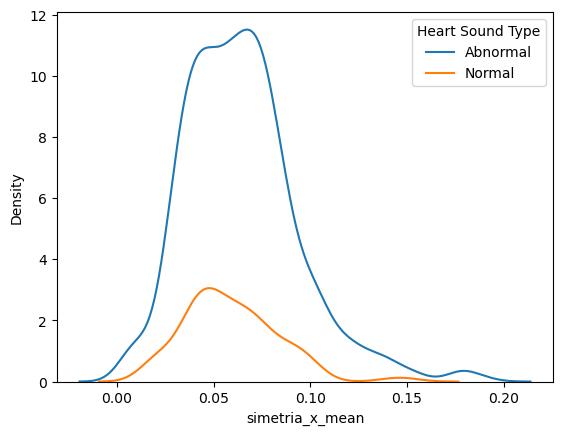

In [122]:
import seaborn as sns
sns.kdeplot(data=HS_agregado_sem_cod_20windows_Binary, x="simetria_x_mean",
            hue="Heart Sound Type")

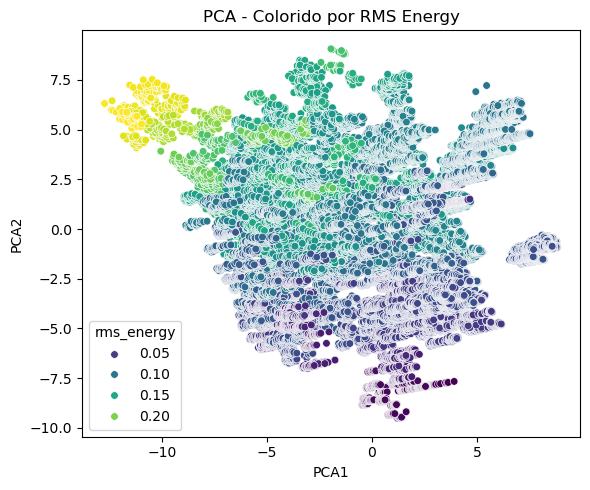

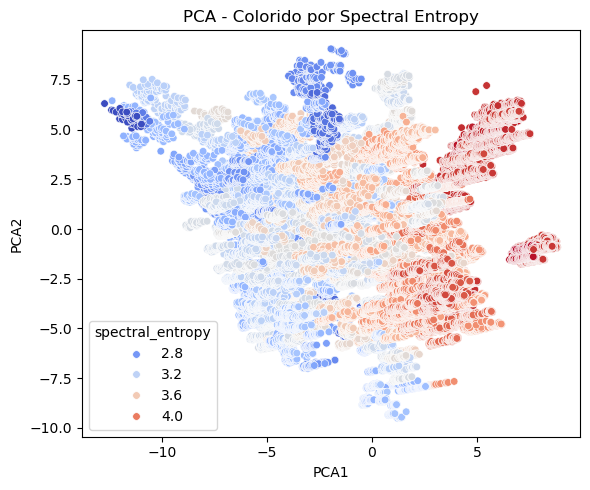

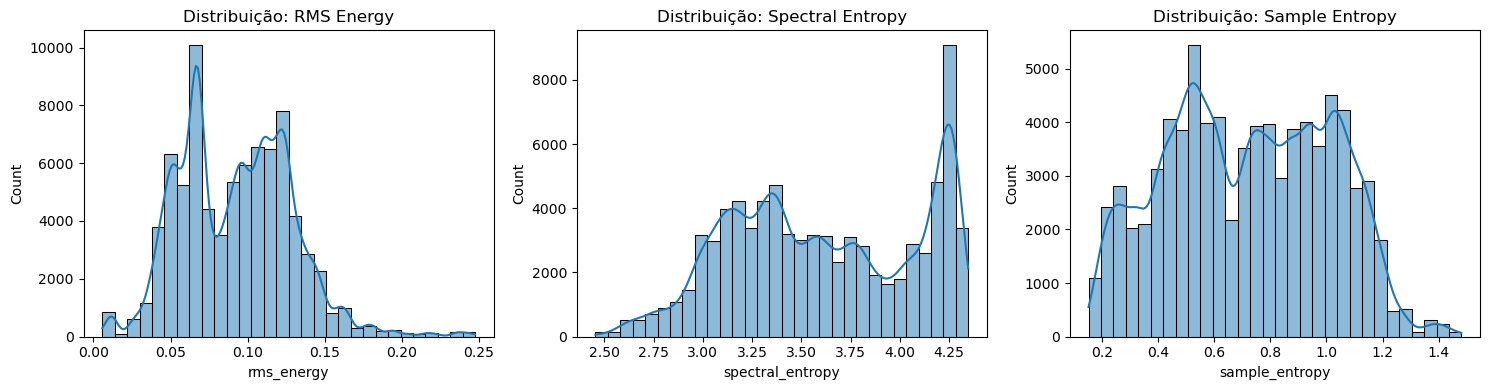

(np.float64(1.0), np.float64(0.0))

In [126]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. PCA com coloração por RMS energy e Spectral Entropy
df_plot = df_sem_cod_HS.copy()
features_for_pca = df_plot.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")
X_scaled = StandardScaler().fit_transform(features_for_pca.drop(
    columns=["rms_energy", "spectral_entropy", "sample_entropy"], errors="ignore"))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_plot["PCA1"] = X_pca[:, 0]
df_plot["PCA2"] = X_pca[:, 1]

# Gráfico 1: Colorido por RMS Energy
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_plot, x="PCA1", y="PCA2",
                hue="rms_energy", palette="viridis", s=30)
plt.title("PCA - Colorido por RMS Energy")
plt.tight_layout()
plt.show()

# Gráfico 2: Colorido por Spectral Entropy
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_plot, x="PCA1", y="PCA2",
                hue="spectral_entropy", palette="coolwarm", s=30)
plt.title("PCA - Colorido por Spectral Entropy")
plt.tight_layout()
plt.show()

# 2. Histogramas das features adicionais

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df_plot["rms_energy"], bins=30, ax=axs[0], kde=True)
axs[0].set_title("Distribuição: RMS Energy")

sns.histplot(df_plot["spectral_entropy"], bins=30, ax=axs[1], kde=True)
axs[1].set_title("Distribuição: Spectral Entropy")

sns.histplot(df_plot["sample_entropy"], bins=30, ax=axs[2], kde=True)
axs[2].set_title("Distribuição: Sample Entropy")

plt.tight_layout()
plt.show()

# 3. Teste simples com Random Forest (validação cruzada binária fictícia)
# Simulando uma coluna binária para teste
df_plot["label"] = (df_plot["sample_entropy"] >
                    df_plot["sample_entropy"].median()).astype(int)

X_model = df_plot.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id", "label", "PCA1", "PCA2"], errors="ignore")
y_model = df_plot["label"]

clf = RandomForestClassifier(random_state=42, n_estimators=100)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_model, y_model, cv=cv, scoring="accuracy")

# Resultado do modelo simples
scores.mean(), scores.std()